# Ray Tracing

**Objetivo:** Implementar ray tracing.

**Referências:**
- https://medium.com/@www.seymour/coding-a-3d-ray-tracing-graphics-engine-from-scratch-f914c12bb162
- https://medium.com/@www.seymour/coding-a-3d-ray-tracing-graphics-engine-using-python-and-c-part-2-9b53bcb6fb1b
- https://observablehq.com/@esperanc/raytracing

## Implementação

### Libraries

In [1]:
import numpy as np

### Classes

An object when hit by a ray could: emit, reflect, absorb, specular reflection (return value)

In [2]:
class Ray:
    def __init__(self, origin, direction):
        self.origin = origin
        self.direction = direction
    
    def at_time_t(self, t):
        return self.origin + t * self.direction

In [3]:
class Material:
    def __init__(self, color, ambient, diffuse, specular, shininess):
        self.color = color
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular
        self.shininess = shininess

In [4]:
epsilon = 10 ** -5

class Sphere:
    def __init__(self, center, radius, material):
        self.center = center
        self.radius = radius
        self.material = material
    
    def normal_at_point(self, point):
        rad = sum(np.square(point - self.center))
        if np.abs(self.radius**2 - rad) < epsilon:
            return 2 * point - self.center
        else:
            raise Exception("Given point is not a point in the Sphere.")

In [5]:
class Light:
    def __init__(self, color, position):
        self.color = color
        self.position = position

### Functions

In [6]:
def length(arr):
    return np.linalg.norm(arr)

In [7]:
def normalize(arr):
    norm = np.linalg.norm(arr)
    return arr / norm

In [8]:
# ref: https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector

def reflection(incident, normal):
    normal = normalize(normal)
    reflected = incident - 2 * (np.dot(incident, normal) * normal)
    return reflected

In [9]:
def ray_hit(sphere, ray):
    oc = ray.origin - sphere.center
    a = np.dot(ray.direction, ray.direction)
    b = 2 * np.dot(oc, ray.direction)
    c = np.dot(oc, oc) - sphere.radius**2

    delta = b**2 - 4*a*c

    if delta >= 0:
        # print("True")
        t1 = (-b + np.sqrt(delta)) / (2*a)
        t2 = (-b - np.sqrt(delta)) / (2*a)
        if np.isreal(t1) and np.isreal(t2):
            return min(t1, t2)
        elif np.isreal(t1):
            return t1
        else:
            return t2
    else:
        # print("False")
        return False

In [10]:
def firstHit(objects, ray):
    distances = []
    times = []
    for obj in objects:
        t = ray_hit(obj, ray)
        if t != False:
            distance = length(ray.origin - ray.at_time_t(t))
            distances.append(distance)
            times.append(t)
    if distances == []:
        return False
    min_distance = min(distances)
    idx = distances.index(min_distance)
    time = times[idx]
    return idx, min_distance, time
        

In [11]:
def ray_tracing(ray, objects, lights, level=1):
    black = np.array([0, 0, 0])
    # Check if we hit anything
    idx_dist_time = firstHit(objects, ray)
    if idx_dist_time == False:
        return black
    elif idx_dist_time != False:
        obj = objects[idx_dist_time[0]]
        dist = idx_dist_time[1]

        # Material properties
        color = obj.material.color
        ambient = obj.material.ambient
        diffuse = obj.material.diffuse
        specular = obj.material.specular
        shininess = obj.material.shininess

        # The final color stats with the ambient color
        rgb = color * ambient

        # The hit point
        q = ray.at_time_t(idx_dist_time[2])
        # print(q-obj.center)
        # print(sum(np.square(q - obj.center)))
        
        # The hit normal
        n = obj.normal_at_point(q)

        # Vector from surface point to viewer
        qv = -ray.direction
        qv = normalize(qv)

        # Take into account each light
        for light in lights:
            # Vector from surface point to light position
            qp = light.position - q
            light_dist = length(qp)
            qp = normalize(qp)
            
            # Cast shadow ray
            shadow_ray = Ray(origin=q, direction=qp)
            shadow_idx_dist_time = firstHit(objects, shadow_ray)
            if (shadow_idx_dist_time != False and shadow_idx_dist_time[1] >= light_dist):
                # Compute diffuse color
                rgb += color * diffuse * max(0, np.dot(qp, n))
            
            # Non-recursive specular computation if term non-zero
            if (level <= 0 and specular > 0):
                ref = reflection(qp, n)
                if (all(ref != black)):
                    print(np.dot(ref, qv))
                    print(shininess)
                    rgb += light.color * specular * np.power(np.dot(ref, qv), shininess)

        # Recursive specular computation if term non-zero
        if (level > 0 and specular > 0):
            # Reflected vector
            ref = reflection(qv, n)
            if (all(ref != black)):
                color = ray_tracing(Ray(origin=q, direction=ref), objects=objects, lights=lights, level=level-1)
                rgb += color * specular
        
        # Clamp to 255
        rgb = rgb % 255
        return rgb

## Testing

In [12]:
red = np.array([255, 0, 0])
green = np.array([0, 255, 0])

# specular = 0.3, shininess = 0.3
mat = Material(color=red, ambient=0.3, diffuse=0.5, specular=0.8, shininess=1)

center = np.array([-20, -20, -20])
radius = 15
sphere = Sphere(center=center, radius=radius, material=mat)

mat2 = Material(color=green, ambient=0.3, diffuse=0.5, specular=0.3, shininess=2)

center2 = np.array([-10, -10, -10])
radius2 = 5
sphere2 = Sphere(center=center2, radius=radius2, material=mat2)

origin = np.array([30, 30, 30])
direction = np.array([-1, -1, -1])
ray = Ray(origin=origin, direction=direction)

In [13]:
idx_dist_time = firstHit([sphere], ray)
print(idx_dist_time)

(0, 71.60254037844386, 41.33974596215561)


In [14]:
objects = [sphere, sphere2]

light = Light(color=np.array([255, 255, 0]), position=np.array([20, 20, 20]))
lights = [light]

In [15]:
ray_tracing(ray, objects, lights)

-1.0
2


array([ 22.95, 122.4 ,   0.  ])

## Making Figure

### Elements of the figure

In [16]:
# Colors
red = np.array([255.0, 0.0, 0.0])
green = np.array([0.0, 255.0, 0.0])
blue = np.array([0.0, 0.0, 255.0])
yellow = np.array([255.0, 255.0, 0.0])

# Material
mat1 = Material(color=red, ambient=0.3, diffuse=0.5, specular=0.8, shininess=1)
mat2 = Material(color=green, ambient=0.3, diffuse=0.5, specular=0.3, shininess=2)

# Spheres
center1 = np.array([-20, -20, -20])
radius1 = 15
sphere1 = Sphere(center=center1, radius=radius1, material=mat1)

center2 = np.array([-10, -10, -10])
radius2 = 5
sphere2 = Sphere(center=center2, radius=radius2, material=mat2)

# Objects
objects = [sphere1, sphere2]
# objects = [sphere1]

# Ray
origin = np.array([30, 30, 30])
direction = np.array([-1, -1, -1])
ray = Ray(origin=origin, direction=direction)

# Lights
light = Light(color=yellow, position=np.array([20, 20, 20]))
lights = [light]

### The figure

-1.0
1
[178.5  40.8   0. ]
[0.7  0.16 0.  ]
-1.0
2
[ 22.95 122.4    0.  ]
[0.09 0.48 0.  ]


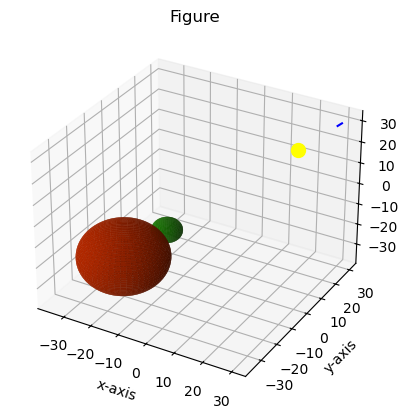

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Definição do plano de projeção
plane_width = 2
plane_height = 2
num_samples = 100

# Criação da figura
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

spheres_coords = []

# Plot da esfera
for sphere in objects:
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = sphere.center[0] + sphere.radius * np.outer(np.cos(u), np.sin(v))
    y = sphere.center[1] + sphere.radius * np.outer(np.sin(u), np.sin(v))
    z = sphere.center[2] + sphere.radius * np.outer(np.ones(np.size(u)), np.cos(v))
    spheres_coords.append([x, y, z])

# Plot do raio
ray_end = ray.origin + ray.direction
ax.plot([ray.origin[0], ray_end[0]], [ray.origin[1], ray_end[1]], [ray.origin[2], ray_end[2]], color='b')

# Plot da luz
ax.scatter(light.position[0], light.position[1], light.position[2], color=light.color / 255, s=100)

# Aplicação do ray tracing na cena
for i in range(len(objects)):
    sphere = objects[i]
    color = ray_tracing(ray=ray, objects=[sphere], lights=lights)
    print(color)
    object_color = ((sphere.material.color + color) % 255) / 255
    print(object_color)
    ax.plot_surface(spheres_coords[i][0], spheres_coords[i][1], spheres_coords[i][2], color=object_color, alpha=1)

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Figure')

plt.show()